"The spice must flow..."(c)

# Реализация

### Установка библиотек, модулей и зависимостей

In [2]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip install -q gym matplotlib
    !pip install wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 23.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


In [1]:
import wandb
import random
import numpy as np
import seaborn as sns
import time
from gym import spaces
import gymnasium as gym
from functools import partial
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline


In [2]:
import warnings

# Бесят эти предупреждения об устаревании
warnings.filterwarnings('ignore', category=DeprecationWarning)


In [3]:
wandb.init(project='Dune-Q', entity='Senich17')


wandb: Currently logged in as: senich17. Use `wandb login --relogin` to force relogin


# Детерминированная среда

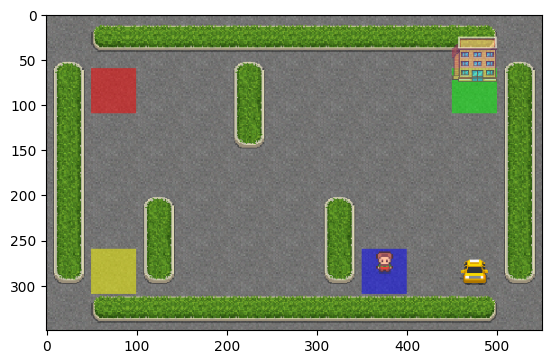

In [7]:
Caladan = gym.make("Taxi-v3", render_mode="rgb_array")
Caladan.reset()
plt.imshow(Caladan.render())


In [8]:
class Model:
    def __init__(self, n_states, n_actions, seed):
        self.n_states = n_states
        self.n_actions = n_actions
        self._rng = np.random.default_rng(seed)
        self.data = []

    def add(self, s: int, a: int, r: float, next_s: int) -> float:
        self.data.append((s, a, r, next_s))
        return r

    def sample(self) -> tuple[int, int, float, int]:
        idx = self._rng.integers(0, len(self.data))
        return self.data[idx]


In [9]:
class PaulAtreides:
    def __init__(self, n_states, n_actions, lr, gamma, eps, f_model, seed):
        self.Q = np.zeros((n_states, n_actions))
        self.model = f_model(n_states, n_actions, seed=seed)
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self._rng = np.random.default_rng(seed)

    def act(self, s):
        if self._rng.random() < self.eps:
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q[s])
        return action

    def update(self, s, a, r, s_n, update_model: bool):
        max_next_action = np.argmax(self.Q[s_n])
        td_target = r + self.gamma * self.Q[s_n][max_next_action]
        td_error = td_target - self.Q[s][a]
        self.Q[s][a] += self.lr * td_error

        if update_model:
            self.model.add(s, a, r, s_n)

    def dream(self, max_steps, **_):
        for _ in range(max_steps):
            s, a, r, s_n = self.model.sample()
            self.update(s, a, r, s_n, update_model=False)


In [10]:
def train(Caladan, agent, n_episodes, on_model_updates, seed, show_progress_schedule=50):
    avg_returns, returns_batch = [], []
    rng = np.random.default_rng(seed)

    for i in range(1, n_episodes):
        state, _ = Caladan.reset(seed=int(rng.integers(10000000)))
        reward, episode_return = 0, 0

        while True:
            action = agent.act(state)

            next_state, reward, terminated, truncated, info = Caladan.step(action)
            agent.update(state, action, reward, next_state, update_model=True)
            state = next_state
            episode_return += reward
            done = terminated or truncated
            if done:
                break
            agent.dream(on_model_updates, state=state)

            # Log episode data
            wandb.log({'State': state, 'Action': action, 'Reward': reward, 'Next State': next_state})

        returns_batch.append(episode_return)

        if i % show_progress_schedule == 0:
            avg_return = np.mean(returns_batch)
            avg_returns.append((i, avg_return))
            returns_batch = []

            wandb.log({'Episode Return': episode_return, 'Average Return': avg_return})

            print(
                f"Episode: {i}, Return: {episode_return}, "
                f"AvgReturn[{show_progress_schedule}]: {avg_return:.0f}"
            )

    return avg_returns


In [12]:
def main():
    wandb.init(project="Dune-Q")

    n_states = Caladan.observation_space.n
    n_actions = Caladan.action_space.n

    print(f"Observation space: {n_states}, Action space: {n_actions}")

    # Генерируем случайное значение seed на основе текущего времени
    seed = int(time.time())

    agent = PaulAtreides(
        n_states,
        n_actions,
        f_model=Model,
        lr=0.05,
        gamma=0.975,
        eps=0.1,
        seed=seed
    )

    avg_returns = train(
        Caladan,
        agent,
        on_model_updates=0,
        seed=seed,
        n_episodes=3001,
    )


In [13]:
# Define the sweep configuration
sweep_config = {
    "method": "grid",
    "parameters": {
        "n_planning_steps": {"values": [1, 5, 10]},
        "n_dreaming_steps": {"values": [1, 3, 5]}  # Add dreaming steps parameter
    }
}


"Процесс нельзя понять, остановив его. Постижение процесса развивается, следуя за ним, догоняя его, сливаясь с ним" (с)

Поэтому запустим алгоритм и будем перебирать параметры, анализируя их влияние.

In [14]:
# Start the sweep
PaulTravel = wandb.sweep(sweep=sweep_config, project="Dune-Q")

# Run the sweep
wandb.agent(PaulTravel, function=main, count=5)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: mh6e457x
Sweep URL: https://wandb.ai/senich17/Dune-Q/sweeps/mh6e457x


wandb: Agent Starting Run: r251yh33 with config:
wandb: 	n_dreaming_steps: 1
wandb: 	n_planning_steps: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Observation space: 500, Action space: 6
Episode: 50, Return: -220, AvgReturn[50]: -373
Episode: 100, Return: -245, AvgReturn[50]: -274
Episode: 150, Return: -308, AvgReturn[50]: -267
Episode: 200, Return: -109, AvgReturn[50]: -235
Episode: 250, Return: -45, AvgReturn[50]: -243
Episode: 300, Return: -290, AvgReturn[50]: -219
Episode: 350, Return: -299, AvgReturn[50]: -189
Episode: 400, Return: -156, AvgReturn[50]: -210
Episode: 450, Return: -236, AvgReturn[50]: -187
Episode: 500, Return: -172, AvgReturn[50]: -173
Episode: 550, Return: -150, AvgReturn[50]: -163
Episode: 600, Return: -219, AvgReturn[50]: -144
Episode: 650, Return: -63, AvgReturn[50]: -128
Episode: 700, Return: -184, AvgReturn[50]: -124
Episode: 750, Return: -137, AvgReturn[50]: -95
Episode: 800, Return: -30, AvgReturn[50]: -108
Episode: 850, Return: -139, AvgReturn[50]: -96
Episode: 900, Return: -31, AvgReturn[50]: -93
Episode: 950, Return: -140, AvgReturn[50]: -68
Episode: 1000, Return: -109, AvgReturn[50]: -72
Episode: 

Action,▅▁▂▄▁▄▅▁▁▄▄▄▄▄▅▁▄▁▄▇▅▅▅▁▅▄▁▇▁▁▁▁█▄▂▄▁▅▂▅
Average Return,▁▃▄▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇████████████████████
Episode Return,▃▂▅▇▁▄▄▄▆▄▇▅▅▅██▅█▆███████▇▇████▇█▇█████
Next State,▂▇▁▃█▁██▇▃▃▄▄▅▄▄▂▅▂▅▄▂▇▇▁▃▄▂▄▄▆▆▆█▁▅▇▂▅▄
Reward,███████████████████▁████████████▁███████
State,▂▇▁▃█▁██▇▃▃▄▄▅▄▄▂▅▂▅▄▂▇▇▁▃▄▂▄▄▆▆▆█▁▅▇▂▅▄
Action,0
Average Return,1.22
Episode Return,10
Next State,479
Reward,-1


wandb: Agent Starting Run: 519mz5bl with config:
wandb: 	n_dreaming_steps: 1
wandb: 	n_planning_steps: 5
wandb: Currently logged in as: senich17. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Observation space: 500, Action space: 6
Episode: 50, Return: -245, AvgReturn[50]: -371
Episode: 100, Return: -254, AvgReturn[50]: -270
Episode: 150, Return: -47, AvgReturn[50]: -245
Episode: 200, Return: -290, AvgReturn[50]: -246
Episode: 250, Return: -254, AvgReturn[50]: -223
Episode: 300, Return: -249, AvgReturn[50]: -221
Episode: 350, Return: -153, AvgReturn[50]: -205
Episode: 400, Return: -141, AvgReturn[50]: -193
Episode: 450, Return: -59, AvgReturn[50]: -182
Episode: 500, Return: -152, AvgReturn[50]: -169
Episode: 550, Return: -263, AvgReturn[50]: -146
Episode: 600, Return: -272, AvgReturn[50]: -151
Episode: 650, Return: -74, AvgReturn[50]: -147
Episode: 700, Return: -53, AvgReturn[50]: -139
Episode: 750, Return: -47, AvgReturn[50]: -112
Episode: 800, Return: -11, AvgReturn[50]: -109
Episode: 850, Return: -182, AvgReturn[50]: -100
Episode: 900, Return: -150, AvgReturn[50]: -78
Episode: 950, Return: -85, AvgReturn[50]: -77
Episode: 1000, Return: -15, AvgReturn[50]: -74
Episode: 10

Action,▁▅█▄▂▅▅▅▂▁▂▅▅▅▄▄▂▅▄▅▂▄▂▂▁▄▅▄▂▂▄▁▄▄▁▁▂▂▂▂
Average Return,▁▃▃▄▄▄▅▅▅▅▆▆▇▇▇▇▇▇▇▇████████████████████
Episode Return,▂▂▁▂▄▄▄▂▆▆▇▃▆▇▅▇▆▇▇█▅█▇▇██▇████▇██▇█▇███
Next State,▇▁▁▂▁▇▄▂▁▆▁▄▅▄▅▅▆▅▃▁▁▁▂▆▄██▃▃▆█▇▅▄▄▆▅▆▃▅
Reward,██▁█████████████████████████████████████
State,▇▁▁▂▁▇▄▂▁▆▁▄▅▄▅▅▆▅▃▁▁▁▂▆▄██▃▃▆█▇▅▄▄▆▅▆▃▅
Action,3
Average Return,2.06
Episode Return,1
Next State,418
Reward,-1


wandb: Agent Starting Run: 8o54aboo with config:
wandb: 	n_dreaming_steps: 1
wandb: 	n_planning_steps: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Observation space: 500, Action space: 6
Episode: 50, Return: -263, AvgReturn[50]: -369
Episode: 100, Return: -452, AvgReturn[50]: -255
Episode: 150, Return: -290, AvgReturn[50]: -273
Episode: 200, Return: -299, AvgReturn[50]: -253
Episode: 250, Return: -75, AvgReturn[50]: -237
Episode: 300, Return: -62, AvgReturn[50]: -213
Episode: 350, Return: -172, AvgReturn[50]: -204
Episode: 400, Return: -144, AvgReturn[50]: -190
Episode: 450, Return: -281, AvgReturn[50]: -176
Episode: 500, Return: -120, AvgReturn[50]: -174
Episode: 550, Return: -244, AvgReturn[50]: -161
Episode: 600, Return: -272, AvgReturn[50]: -157
Episode: 650, Return: -78, AvgReturn[50]: -123
Episode: 700, Return: 3, AvgReturn[50]: -125
Episode: 750, Return: -78, AvgReturn[50]: -110
Episode: 800, Return: -132, AvgReturn[50]: -76
Episode: 850, Return: -185, AvgReturn[50]: -90
Episode: 900, Return: -213, AvgReturn[50]: -87
Episode: 950, Return: -39, AvgReturn[50]: -87
Episode: 1000, Return: 4, AvgReturn[50]: -72
Episode: 1050, R

Action,▁▂▄▄▂▁▅▅▁▅▁▄▅▁█▂▂▄▄▁▄▅▄▁▄▅▄▂▁▁▁▅▅▅▄▇▄▁▁▁
Average Return,▁▃▃▃▄▄▅▅▆▆▇▆▆▇▇▇▇▇██████████████████████
Episode Return,▄▁▃▇▅▆▆▄▇█▆▅▇███████▇██▇███▇████████▇███
Next State,▆▁▇▅▁█▃▂█▂▇▃▆▄▄▆▄▃▆▂▆▇▃▅▄▄▁▅▅▅▅▃▄▁▅▁▁▄█▃
Reward,██████████████▁█████████████████████████
State,▆▁▇▅▁█▃▂█▂▇▃▆▄▄▆▄▃▆▂▆▇▃▅▄▄▁▅▅▅▅▃▄▁▅▁▁▄█▃
Action,1
Average Return,0.74
Episode Return,-6
Next State,16
Reward,-1


wandb: Agent Starting Run: izcibsa2 with config:
wandb: 	n_dreaming_steps: 3
wandb: 	n_planning_steps: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Observation space: 500, Action space: 6
Episode: 50, Return: -200, AvgReturn[50]: -377
Episode: 100, Return: -272, AvgReturn[50]: -270
Episode: 150, Return: -219, AvgReturn[50]: -253
Episode: 200, Return: -254, AvgReturn[50]: -247
Episode: 250, Return: -271, AvgReturn[50]: -232
Episode: 300, Return: 6, AvgReturn[50]: -219
Episode: 350, Return: -290, AvgReturn[50]: -220
Episode: 400, Return: -272, AvgReturn[50]: -200
Episode: 450, Return: -326, AvgReturn[50]: -175
Episode: 500, Return: -259, AvgReturn[50]: -153
Episode: 550, Return: -294, AvgReturn[50]: -160
Episode: 600, Return: -371, AvgReturn[50]: -139
Episode: 650, Return: -5, AvgReturn[50]: -146
Episode: 700, Return: 10, AvgReturn[50]: -132
Episode: 750, Return: -308, AvgReturn[50]: -102
Episode: 800, Return: -43, AvgReturn[50]: -88
Episode: 850, Return: -192, AvgReturn[50]: -92
Episode: 900, Return: -94, AvgReturn[50]: -84
Episode: 950, Return: -82, AvgReturn[50]: -80
Episode: 1000, Return: -49, AvgReturn[50]: -79
Episode: 1050, R

Action,█▆▃▃█▆▅▃▃▅▅▆▃▅▃▁▆▆▃▃▃▃▁▅▅█▃▆▅▆█▃▆▃▅▃▆▆▅▆
Average Return,▁▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█▇▇███████████████████
Episode Return,▃▂▂▂▁▂▂▁██▇▃▆▇█▆▇▆█▇█████▇█▇███▇████████
Next State,▇▃▂▆▅▅▇▁▄█▁▂▂▂▇▃▄▅▁▃▄▆▃▃▂▅▆▇▁▆▂▇▇▇▆▆▅█▆▅
Reward,▁███▁████████████████████▁██████████████
State,▇▃▂▆▅▅▇▁▄█▁▂▂▂▇▃▄▅▁▃▄▆▃▃▂▅▆▇▁▆▂▇▇▇▆▆▅█▆▅
Action,1
Average Return,2.58
Episode Return,10
Next State,97
Reward,-1


wandb: Agent Starting Run: n0x9fv9s with config:
wandb: 	n_dreaming_steps: 3
wandb: 	n_planning_steps: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Observation space: 500, Action space: 6
Episode: 50, Return: -380, AvgReturn[50]: -379
Episode: 100, Return: -245, AvgReturn[50]: -265
Episode: 150, Return: -22, AvgReturn[50]: -259
Episode: 200, Return: -225, AvgReturn[50]: -245
Episode: 250, Return: -272, AvgReturn[50]: -230
Episode: 300, Return: -254, AvgReturn[50]: -209
Episode: 350, Return: -24, AvgReturn[50]: -216
Episode: 400, Return: -317, AvgReturn[50]: -204
Episode: 450, Return: -281, AvgReturn[50]: -181
Episode: 500, Return: -294, AvgReturn[50]: -184
Episode: 550, Return: -265, AvgReturn[50]: -136
Episode: 600, Return: -106, AvgReturn[50]: -129
Episode: 650, Return: -34, AvgReturn[50]: -136
Episode: 700, Return: -122, AvgReturn[50]: -125
Episode: 750, Return: -33, AvgReturn[50]: -114
Episode: 800, Return: -4, AvgReturn[50]: -128
Episode: 850, Return: 13, AvgReturn[50]: -103
Episode: 900, Return: -139, AvgReturn[50]: -60
Episode: 950, Return: -158, AvgReturn[50]: -77
Episode: 1000, Return: -35, AvgReturn[50]: -67
Episode: 105

Action,█▃▃▅▃▁▃▆▁▁▅▃▆▅▃▅▁▁▁▅▅▃▁▆█▅▆▅▆▃▆▅▁▆▅▅▅▆▃▆
Average Return,▁▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇█████████████████████
Episode Return,▁▃▄▃▇▂▃▃▇▆██▅▇█▆▄▇▇▆▇▇▇████▇████████████
Next State,█▅▂▄▃▅▃▆▇█▂▆▅▂▂█▆█▇▅▄▅▇▆▂█▅▇▁▂▄▆▄▇▅▄▅▅▃▂
Reward,▁███████████████████████▁███████████████
State,█▅▂▄▃▅▃▆▇█▂▆▅▂▂█▆█▇▅▄▅▇▆▂█▅▇▁▂▄▆▄▇▅▄▅▅▃▂
Action,1
Average Return,2.06
Episode Return,5
Next State,97
Reward,-1


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x796d1e87a980>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

WandB ссылка на отчет: https://wandb.ai/senich17/Dune-Q/reports/Paul-on-Caladan--Vmlldzo4MDIwNjUx?accessToken=oh7t2i45j5oucujri0noy3rofgqf7y1qe82mknrcnkaonur85xbsa4tebr2o01ma

## Выводы по гиперпараметрам

В мире обучения с подкреплением, как в песках Арракиса, гиперпараметры играют важную роль, формируя путь к успеху или провалу...

### 1. Пол Атрейдес на Каладане с n_dreaming_steps: 1 и n_planning_steps: 1

Средний возврат составил 1.22, а возврат за эпизод был 10. Это свидетельствует о том, что модель, подобно молодому Полу Атрейдесу, имеет общую положительную тенденцию, но иногда может сталкиваться с вызовами. Хотя средний возврат высок, иногда возникают отдельные эпизоды с более низкими возвратами, что указывает на необходимость дальнейшего улучшения модели и ее стабилизацию.

### 2. Лето Атрейдес – управляющий Каладаном с n_dreaming_steps: 1 и n_planning_steps: 5

Средний возврат составил 2.06, а возврат за эпизод был 1. В этом случае модель, как и герцог Лето Атрейдес, проявляет стабильность и умение находить баланс. Хотя средний возврат немного выше, отдельные эпизоды могут быть менее успешными, что подчеркивает важность постоянного улучшения стратегии.

### 3. Лето и Джессика с n_dreaming_steps: 1 и n_planning_steps: 10

Средний возврат составил 0.74, а возврат за эпизод был -6. Это указывает на то, что модель стремится к идеалу, как Лето и Джессика, но её успехи неравномерны. при сочетании параметров таким образом, как в этом запуске, модель может столкнуться с тем, что застревает в минимумах (но это не точно). Чтобы точно определить причину отрицательного возврата за эпизоды, необходимо более глубокое анализировать обучение модели. Например, негативный возврат эпизодов может быть обусловлен недостаточным исследованием среды.

### 4. Пол и его тренировки с Дунканом Айдахо с n_dreaming_steps: 3 и n_planning_steps: 1

Средний возврат составил 2.58, а возврат за эпизод был 10. Модель, подобно Полу, получает ценный опыт и стремится к совершенству, ни смотря на скачки показателей за эпизоды. Высокие показатели указывают на то, что необходимо точно и детально анализировать параметры и шаг за шагом наблюдать за их влиянием на поведение модели. Что интересно в данном запуске, так это то, что при низком значении n_planning_steps и высоком n_dreaming_steps результат впечатляющий (на моей практике в 100500 раз, которые я переделывала эту работу, при таких значениях, особенно в стохаститческой среде, все выглядит совсем печально).

### 5. Пол и его друг Гурни Халлек с n_dreaming_steps: 3 и n_planning_steps: 5

Средний возврат составил 2.06, а возврат за эпизод был 5. Модель, подобно Полу и его другу Гурни Халлеку, находит радость и удовлетворение в своей стратегии. В целом, средний возврат положителен, и кажется, будто такие значения параметров неплохо сбалансированы. Это будет заметно и в дальнейших экспериментах. Важно четко понимать, что сильные перекосы в параметрах будут давать модели нестабильность и неустойчивость, которые в свою очередь приведут к низким показателям и не качественному обучению. В целом модели РЛ и так плохо обобщаются, поэтому не надо подливать масла в огонь :)

### Общий вывод

Модели с разными наборами гиперпараметров представляют собой различные эпизоды жизни героев на Каладане. Понимание и оптимизация этих параметров помогает модели достигать лучших результатов и преодолевать вызовы, создавая прочный фундамент для будущих достижений. Естественно, что такое небольшое количество эпизодов так же влияет на результаты, но тем не менее даже при таких игрушечных экспереметах заметна разница.

# Стохастическая среда

"Привычка к одним лишь победам сама по себе может стать слабостью." (С)

Поэтому добавим нашему агенту препятствия на пути к его величию.

In [4]:
class SandStormArrakis(gym.Wrapper):
    def __init__(self, env, wind_prob=0.2, wind_strength=1):
        super().__init__(env)
        self.wind_prob = wind_prob  # Вероятность воздействия ветра
        self.wind_strength = wind_strength  # Сила воздействия ветра

    def step(self, action):
        # делаем шаг в оригинальной среде
        next_state, reward, terminated, truncated, info = self.env.step(action)

        # Определяем, будет ли воздействие ветра на текущем шаге
        if np.random.rand() < self.wind_prob:
            # применим ветер к среде
            wind_action = np.random.choice([-self.wind_strength, 0, self.wind_strength])
            next_state = (next_state + wind_action) % self.env.observation_space.n

        return next_state, reward, terminated, truncated, info


In [5]:
# Тут у нас будет моделька
class Model:
    def __init__(self, n_states, n_actions, seed):
        self.n_states = n_states
        self.n_actions = n_actions
        self._rng = np.random.default_rng(seed)
        self.data = []

    def add(self, s, a, r, next_s):
        self.data.append((s, a, r, next_s))
        return r

    def sample(self):
        idx = self._rng.integers(0, len(self.data))
        return self.data[idx]


"— Ты должен выбрать себе имя, которым мы будем называть тебя открыто.
— Как вы называете тень от второй луны?
— Тень второй луны мы называем Муад’диб.
— Можно ли мне называть себя Пол Муад’диб?
— Отныне ты будешь Пол Муад’диб." (с)

In [6]:
# А тут у нас живет агент Пол Муад’диб
class Muaddib:
    def __init__(self, n_states, n_actions, lr, gamma, eps, f_model, seed):
        self.Q = np.zeros((n_states, n_actions))
        self.model = f_model(n_states, n_actions, seed=seed)
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self.n_states = n_states
        self._rng = np.random.default_rng(seed)

    def act(self, s):
        if s >= self.n_states:
            raise ValueError(f"State index {s} is out of bounds for Q-table with size {self.n_states}")

        if self._rng.random() < self.eps:
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q[s])
        return action

    def update(self, s, a, r, s_n, update_model: bool):
        if s >= self.n_states or s_n >= self.n_states:
            raise ValueError(f"State index {s} or next state index {s_n} is out of bounds for Q-table with size {self.n_states}")

        max_next_action = np.argmax(self.Q[s_n])
        td_target = r + self.gamma * self.Q[s_n][max_next_action]
        td_error = td_target - self.Q[s][a]
        self.Q[s][a] += self.lr * td_error

        if update_model:
            self.model.add(s, a, r, s_n)

    def dream(self, max_steps, **_):
        for _ in range(max_steps):
            s, a, r, s_n = self.model.sample()

            if s >= self.n_states or s_n >= self.n_states:
                print(f"Sampled state index {s} or next state index {s_n} is out of bounds for Q-table with size {self.n_states}")
                continue

            self.update(s, a, r, s_n, update_model=False)


In [7]:
# Здесь творится магия
def train(Arrakis, agent, n_episodes, on_model_updates, seed, show_progress_schedule=50):
    returns_batch = []  # Инициализация списка для сбора возвратов
    rng = np.random.default_rng(seed)
    avg_returns = []  # Инициализация списка для средних возвратов

    for i in range(1, n_episodes):
        state, _ = Arrakis.reset(seed=int(rng.integers(10000000)))
        reward, episode_return = 0, 0

        while True:
            action = agent.act(state)

            # Выполним действия в среде
            next_state, reward, terminated, truncated, info = Arrakis.step(action)
            agent.update(state, action, reward, next_state, update_model=True)
            state = next_state
            episode_return += reward
            done = terminated or truncated
            if done:
                break
            agent.dream(on_model_updates, state=state)

        returns_batch.append(episode_return)

        if i % show_progress_schedule == 0:
            avg_return = np.mean(returns_batch)

            # про лргирование прогресса обучения и метрик с помощью wandb не забываем
            wandb.log({'Episode Return': episode_return, 'Average Return': avg_return})

            print(
                f"Episode: {i}, Return: {episode_return}, "
                f"AvgReturn[{show_progress_schedule}]: {avg_return:.0f}"
            )

            avg_returns.append(avg_return)  # Добавление среднего возврата в список

    return avg_returns


In [8]:
def main():

    wandb.init(project="Dune-Q")

    Arrakis = gym.make("Taxi-v3")
    Arrakis = SandStormArrakis(Arrakis)

    # Проверка пространства наблюдений
    n_states = Arrakis.observation_space.n
    n_actions = Arrakis.action_space.n

    print(f"Observation space: {n_states}, Action space: {n_actions}")

    # Инициализация агента
    agent = Muaddib(
        n_states,
        n_actions,
        f_model=Model,
        lr=0.05,
        gamma=0.975,
        eps=0.1,
        seed=42,
    )

    # Обучения агента с текущими параметрами
    avg_returns = train(
        Arrakis,
        agent,
        on_model_updates=0,
        seed=42,
        n_episodes=3001,
    )


In [9]:
# Define the sweep configuration
sweep_config = {
    "method": "grid",
    "parameters": {
        "n_planning_steps": {"values": [1, 5, 10]},
        "n_dreaming_steps": {"values": [1, 3, 5]}  # Add dreaming steps parameter
    }
}


"Я не боюсь, я не должен бояться. Ибо страх убивает разум. Страх есть малая смерть, влекущая за собой полное уничтожение. Я встречу свой страх и приму его. Я позволю ему пройти надо мной и сквозь меня. И когда он пройдет через меня, я обращу свой внутренний взор на его путь; и там, где был страх, не останется ничего. Останусь лишь я, я сам." Muaddib

Ну штош, теперь можно начать обучение с разными гиперпараметрами.

In [10]:
# Start the sweep
MuaddibTravel = wandb.sweep(sweep=sweep_config, project="Dune-Q")

# Run the sweep
wandb.agent(MuaddibTravel, function=main, count=5)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: ai15t1kj
Sweep URL: https://wandb.ai/senich17/Dune-Q/sweeps/ai15t1kj


wandb: Agent Starting Run: lqp5viqo with config:
wandb: 	n_dreaming_steps: 1
wandb: 	n_planning_steps: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Observation space: 500, Action space: 6
Episode: 50, Return: -272, AvgReturn[50]: -368
Episode: 100, Return: -261, AvgReturn[50]: -336
Episode: 150, Return: -192, AvgReturn[50]: -316
Episode: 200, Return: -335, AvgReturn[50]: -302
Episode: 250, Return: -254, AvgReturn[50]: -290
Episode: 300, Return: -299, AvgReturn[50]: -284
Episode: 350, Return: -120, AvgReturn[50]: -277
Episode: 400, Return: -262, AvgReturn[50]: -271
Episode: 450, Return: -108, AvgReturn[50]: -265
Episode: 500, Return: -281, AvgReturn[50]: -263
Episode: 550, Return: -90, AvgReturn[50]: -261
Episode: 600, Return: -272, AvgReturn[50]: -260
Episode: 650, Return: -272, AvgReturn[50]: -255
Episode: 700, Return: -208, AvgReturn[50]: -251
Episode: 750, Return: -74, AvgReturn[50]: -248
Episode: 800, Return: -281, AvgReturn[50]: -245
Episode: 850, Return: -102, AvgReturn[50]: -243
Episode: 900, Return: -206, AvgReturn[50]: -239
Episode: 950, Return: -74, AvgReturn[50]: -236
Episode: 1000, Return: -299, AvgReturn[50]: -233
Epi

Average Return,▁▂▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
Episode Return,▂▂▁▃▅▂▂▆▂▄▂▆▆▂▁▅▃▄▃▄▃▇▂▃▇█▆███▇▇▂▇▇▇▂▇██
Average Return,-138.19733
Episode Return,0


wandb: Agent Starting Run: c54p7p81 with config:
wandb: 	n_dreaming_steps: 1
wandb: 	n_planning_steps: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Observation space: 500, Action space: 6
Episode: 50, Return: -281, AvgReturn[50]: -379
Episode: 100, Return: -416, AvgReturn[50]: -345
Episode: 150, Return: -290, AvgReturn[50]: -325
Episode: 200, Return: -308, AvgReturn[50]: -311
Episode: 250, Return: -272, AvgReturn[50]: -299
Episode: 300, Return: -272, AvgReturn[50]: -290
Episode: 350, Return: -290, AvgReturn[50]: -283
Episode: 400, Return: -165, AvgReturn[50]: -277
Episode: 450, Return: -299, AvgReturn[50]: -273
Episode: 500, Return: -141, AvgReturn[50]: -268
Episode: 550, Return: -290, AvgReturn[50]: -265
Episode: 600, Return: -281, AvgReturn[50]: -262
Episode: 650, Return: -127, AvgReturn[50]: -257
Episode: 700, Return: -189, AvgReturn[50]: -253
Episode: 750, Return: -91, AvgReturn[50]: -248
Episode: 800, Return: -43, AvgReturn[50]: -244
Episode: 850, Return: -245, AvgReturn[50]: -240
Episode: 900, Return: -254, AvgReturn[50]: -237
Episode: 950, Return: -290, AvgReturn[50]: -234
Episode: 1000, Return: -263, AvgReturn[50]: -231
Ep

Average Return,▁▂▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
Episode Return,▃▁▃▃▃▅▅▃▆▅▇▄▃▃▃▆▆▄▇▇▇▆▇▇██▇███▆▇▇█▇█▇▇█▇
Average Return,-130.76467
Episode Return,-56


wandb: Agent Starting Run: qty3chx5 with config:
wandb: 	n_dreaming_steps: 1
wandb: 	n_planning_steps: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Observation space: 500, Action space: 6
Episode: 50, Return: -272, AvgReturn[50]: -373
Episode: 100, Return: -308, AvgReturn[50]: -338
Episode: 150, Return: -317, AvgReturn[50]: -319
Episode: 200, Return: -272, AvgReturn[50]: -309
Episode: 250, Return: -263, AvgReturn[50]: -298
Episode: 300, Return: -299, AvgReturn[50]: -292
Episode: 350, Return: -106, AvgReturn[50]: -285
Episode: 400, Return: -254, AvgReturn[50]: -274
Episode: 450, Return: -150, AvgReturn[50]: -271
Episode: 500, Return: -254, AvgReturn[50]: -266
Episode: 550, Return: -353, AvgReturn[50]: -261
Episode: 600, Return: -135, AvgReturn[50]: -259
Episode: 650, Return: -60, AvgReturn[50]: -254
Episode: 700, Return: -62, AvgReturn[50]: -250
Episode: 750, Return: -19, AvgReturn[50]: -245
Episode: 800, Return: -227, AvgReturn[50]: -242
Episode: 850, Return: -125, AvgReturn[50]: -239
Episode: 900, Return: -317, AvgReturn[50]: -236
Episode: 950, Return: -308, AvgReturn[50]: -233
Episode: 1000, Return: -254, AvgReturn[50]: -232
Epi

Average Return,▁▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
Episode Return,▃▂▃▃▆▃▃▁▇▇▃▅▂▃▆▃▆▃▇▄▇▆▂▇▇█▇▇██▇▅▆▇▆█▇▆██
Average Return,-121.96233
Episode Return,-12


wandb: Agent Starting Run: 8uu697sg with config:
wandb: 	n_dreaming_steps: 3
wandb: 	n_planning_steps: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Observation space: 500, Action space: 6
Episode: 50, Return: -299, AvgReturn[50]: -377
Episode: 100, Return: -335, AvgReturn[50]: -343
Episode: 150, Return: -272, AvgReturn[50]: -322
Episode: 200, Return: -208, AvgReturn[50]: -309
Episode: 250, Return: -299, AvgReturn[50]: -296
Episode: 300, Return: -263, AvgReturn[50]: -289
Episode: 350, Return: -308, AvgReturn[50]: -280
Episode: 400, Return: -299, AvgReturn[50]: -274
Episode: 450, Return: -281, AvgReturn[50]: -269
Episode: 500, Return: -299, AvgReturn[50]: -266
Episode: 550, Return: -130, AvgReturn[50]: -263
Episode: 600, Return: -308, AvgReturn[50]: -259
Episode: 650, Return: -89, AvgReturn[50]: -255
Episode: 700, Return: -362, AvgReturn[50]: -252
Episode: 750, Return: -62, AvgReturn[50]: -247
Episode: 800, Return: -86, AvgReturn[50]: -243
Episode: 850, Return: -263, AvgReturn[50]: -240
Episode: 900, Return: -192, AvgReturn[50]: -237
Episode: 950, Return: -263, AvgReturn[50]: -234
Episode: 1000, Return: -245, AvgReturn[50]: -231
Epi

Average Return,▁▂▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
Episode Return,▂▂▄▂▂▂▂▅▆▁▆▃▃▃▅▆▆▇▄▃█▅▂▇██▄▇██▅▇▅▆██▇██▆
Average Return,-138.01267
Episode Return,-79


wandb: Agent Starting Run: lbr4hiyt with config:
wandb: 	n_dreaming_steps: 3
wandb: 	n_planning_steps: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Observation space: 500, Action space: 6
Episode: 50, Return: -443, AvgReturn[50]: -366
Episode: 100, Return: -425, AvgReturn[50]: -338
Episode: 150, Return: -299, AvgReturn[50]: -312
Episode: 200, Return: -290, AvgReturn[50]: -300
Episode: 250, Return: -107, AvgReturn[50]: -288
Episode: 300, Return: -308, AvgReturn[50]: -283
Episode: 350, Return: -236, AvgReturn[50]: -276
Episode: 400, Return: -183, AvgReturn[50]: -270
Episode: 450, Return: -61, AvgReturn[50]: -267
Episode: 500, Return: -263, AvgReturn[50]: -263
Episode: 550, Return: -198, AvgReturn[50]: -260
Episode: 600, Return: -254, AvgReturn[50]: -257
Episode: 650, Return: -237, AvgReturn[50]: -252
Episode: 700, Return: -254, AvgReturn[50]: -249
Episode: 750, Return: -272, AvgReturn[50]: -247
Episode: 800, Return: -301, AvgReturn[50]: -244
Episode: 850, Return: -102, AvgReturn[50]: -241
Episode: 900, Return: -239, AvgReturn[50]: -237
Episode: 950, Return: -168, AvgReturn[50]: -233
Episode: 1000, Return: -254, AvgReturn[50]: -231
E

Average Return,▁▂▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
Episode Return,▁▁▃▆▄▅▄▅▄▄▃▆▅▄▇█▄▆▃▇▅▇▆███▆▇▆██▇▇█▅█▇▇█▇
Average Return,-134.04933
Episode Return,-51


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7e6dca43db40>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

Прилагаю ссылку на WandB, чтобы посмотреть на параметры и результаты https://api.wandb.ai/links/senich17/ky83q8g3

## Выводы по гиперпараметрам

### 1. Прибытие Пола на Арракис с n_dreaming_steps: 1, n_planning_steps: 1

Средний возврат составил -138.19733, а возврат за эпизод был 0. В начале своего пути модель, как молодой Пол Атрейдес, только что прибывший на Арракис. Неопытная и неосведомленная о суровых реалиях загадочной планеты, она сталкивается с многочисленными трудностями, такими как песчаные бури, засуха, и нападения на спайс-майнеры. Она ещё не обрела достаточного опыта и планирования, чтобы успешно противостоять вызовам планеты.

### 2. Прозрение в пустыне с n_dreaming_steps: 1, n_planning_steps: 5

Повышение n_planning_steps до 5 позволило модели лучше планировать свои действия, что улучшило средний возврат до -130.76467 (по сравнению с -138.19733 в предыдущем запуске), но возврат за эпизод стал тревожно низким (-56). На Арракисе, где вода ценится дороже золота, а спайс правит судьбами, Пол учился балансировать между видениями и реальностью, между мечтами о свободе и жестокой борьбой за выживание. Планета учила его, что истинная сила заключается не только в умениях и знаниях, но и в умении видеть то, что скрыто от глаз.


### 3. Фримены и их предводитель с n_dreaming_steps: 1, n_planning_steps: 10

По мере того, как средний возврат и возврат за эпизод растут -121.96233 и -12 соответственно (в сравнении в предыдущим запуском), в результате увеличения n_planning_steps, модель становится подобной Стилгару, опытному лидеру фрименов. Ее стратегия позволяет ей справляться с трудностями, находить оптимальные решения и в результате чего она демонстрирует значительные успехи... Но, увы, переменчивая природа планеты иногда все еще чинит препятствия.

### 4. Видения Алии в пустыне с n_dreaming_steps: 3, n_planning_steps: 1

Увеличение n_dreaming_steps до 3 позволило модели лучше улавливать возможности и вероятности, подобно видениям Алии Атрейдес, но с n_planning_steps, равным 1, модель не всегда могла воплотить пророчества в реальность. Это отражалось на результатах: средний возврат составил -138.01267, а возврат за эпизод -79. Алия, обладая силой и мудростью не по возрасту, часто оказывалась обузой для самой себя, так как её видения не всегда могли компенсировать недостаток опыта и стратегического планирования, что показало модели, что одни только видения не гарант успеха.

### 5. Гости с Салусы Секундус с n_dreaming_steps: 3, n_planning_steps: 5

В данном запуске модель произвела впечатление, аналогичное эффекту, который производили Сардаукары в мире. Средний возврат (-134.04933) демонстрировал ее внушительный потенциал. Но вот возврат за эпизод (-51) не вызывал у Пола и Фрименов такого же ужаса, как у всех остальных подданых императора. В итоге, несмотря на впечатляющий потенциал модели в данном запуске, она оказалась на стороне проигравших.

## Общий вывод

Проведенный анализ различных комбинаций гиперпараметров n_dreaming_steps и n_planning_steps позволяет сделать следующие выводы:

Мы установили, что увеличение значения n_planning_steps способствует улучшению среднего возврата модели. Это свидетельствует о том, что эффективное стратегическое планирование играет ключевую роль в успешной адаптации модели к условиям планеты.

Однако при использовании слишком высоких значений n_planning_steps наблюдается снижение возврата за эпизод, что указывает на необходимость баланса между планированием и эффективной реализацией стратегии. Иначе никакие Фриманы не помогут.

Увеличение значения n_dreaming_steps также может способствовать улучшению среднего возврата модели, позволяя ей лучше распознавать возможности и вероятности. Однако необходимо учитывать, что слишком высокие значения этого параметра могут привести к потере фокуса и недостаточной концентрации на планировании стратегии (собственно, что происходило в предыдущих работах, при высоких показателях эпсилона).

Таким образом, оптимальный выбор гиперпараметров зависит от конкретных условий задачи и требует баланса между способностью модели к стратегическому планированию и ее способностью адаптироваться к изменяющимся условиям. Будь как Пол, адаптируйся и выживай!

P.S.: Так же очень заметно, что модели нужно больше времени для обучения в стохастической среде(ну в нашем случае это не прям стохастичность, это так, ерунда), поэтому и результаты разительно отличаются от результатов, которые были показаны в оригинальной среде.

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
from IPython.display import Image


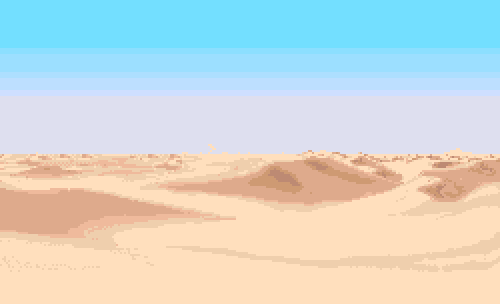

In [6]:
fname = '/content/drive/MyDrive/Игры.gif'
Image(open(fname, 'rb').read())  # local


P.S.: В процессе работы над этой домашкой ни один Шаи'хулуд не пострадал.
По какому-то закону Мерфи всю дорогу у меня ломался пайп, решить эту проблему так и не удалось, но в целом это не повлияло на логирование показателей и работу моделей.